# Lensing Bayesian Inference Workflow

This notebook demonstrates a complete Bayesian inference workflow for weak gravitational lensing:

1. **Gradient Analysis**: Compute and visualize gradients of the forward model w.r.t. cosmological parameters
2. **Synthetic Observations**: Generate fiducial model predictions (convergence maps and lightcone)
3. **MCMC Sampling**: Infer cosmological parameters from observations using NUTS/HMC/MCLMC
4. **Results Analysis**: Plot posteriors and compare inferred vs. true initial conditions

The notebook is structured to allow resuming from the MCMC sampling section without regenerating observations.

## 1. Imports

## Important Notes

**⚠️ NumPyro Sharding Limitation:**
NumPyro does NOT support distributed sharding with checkpoint resumption. When resuming from a saved state, sharding information is lost. For distributed/sharded workflows, use `backend="blackjax"`.

**Spherical vs Flat Geometry:**
- Spherical geometry uses HEALPix with visibility masking (only visible pixels are sampled)
- Flat geometry uses Cartesian coordinates (all pixels within field)
- Use `reconstruct_full_kappa()` to convert visible-pixel maps to full HEALPix maps for plotting

In [22]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from jaxpm.spherical import spherical_visibility_mask
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import (
    compute_box_size_from_redshift,
    compute_max_redshift_from_box_size,
    make_full_field_model,
)
from fwd_model_tools.plotting import (
    plot_ic,
    plot_kappa,
    plot_lightcone,
    plot_posterior,
)
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

JAX devices: 1
JAX backend: cpu


## 2. Configuration Parameters

Edit these parameters to customize the workflow. These correspond to the argparse arguments in `run_lensing_model.py`.

In [16]:
output_dir = "output_notebook"
box_shape = (64, 64, 64)
box_size = None
max_redshift = 0.5
geometry = "spherical"
observer_position = (0.5, 0.5, 1.0)
num_warmup = 50
num_samples = 50
batch_count = 5
sampler = "MCLMC"  # "NUTS", "HMC", or "MCLMC"
backend = "blackjax"  # "blackjax" recommended for sharded runs (see Important Notes below)
sigma_e = 0.3
magick_seed = 42
pdims = (4, 2)

gradient_offset_omega_c = 0.1
gradient_offset_sigma8 = 0.1

## 3. Setup Functions

In [17]:
def setup_output_dir(output_dir):
    output_dir = Path(output_dir)
    plots_dir = output_dir / "plots"
    samples_dir = output_dir / "samples"
    data_dir = output_dir / "data"

    plots_dir.mkdir(parents=True, exist_ok=True)
    samples_dir.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, plots_dir, samples_dir, data_dir


def setup_sharding(pdims=(4, 2)):
    if jax.device_count() > 1:
        from jax.sharding import NamedSharding
        from jax.sharding import PartitionSpec as P

        mesh = jax.make_mesh(pdims, ("x", "y"))
        sharding = NamedSharding(mesh, P("x", "y"))
        print(f"Using sharding with mesh: {pdims}")
    else:
        sharding = None
        print("Single device mode - no sharding")

    return sharding


def create_redshift_distribution(
    cosmo,
    box_size=None,
    observer_position=(0.5, 0.5, 0.5),
    geometry="spherical",
    max_redshift=None,
):
    print("\n" + "=" * 60)
    print("Creating redshift distribution")
    print("=" * 60)

    if box_size is None and max_redshift is None:
        raise ValueError("Either box_size or max_redshift must be provided")

    if box_size is None:
        box_size = compute_box_size_from_redshift(cosmo, max_redshift,
                                                  observer_position)
        print(
            f"Auto-computed box size: {box_size} Mpc/h for max redshift {max_redshift}"
        )
    elif max_redshift is None:
        max_redshift = compute_max_redshift_from_box_size(
            cosmo, box_size, observer_position)
        print(
            f"Auto-computed max redshift: {max_redshift} for box size {box_size} Mpc/h"
        )

    z = jnp.linspace(0, max_redshift, 1000)
    z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
    z_centers = jnp.round(z_centers, 3)
    print(f"z_centers = {z_centers}")

    nz_shear = [
        jc.redshift.kde_nz(
            z,
            norm.pdf(z, loc=z_center, scale=0.12),
            bw=0.01,
            zmax=max_redshift,
            gals_per_arcmin2=g,
        ) for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
    ]
    nbins = len(nz_shear)

    return nz_shear, nbins, max_redshift, box_size


output_dir_path, plots_dir, samples_dir, data_dir = setup_output_dir(output_dir)
sharding = setup_sharding(pdims)
fiducial_cosmology = Planck18()

nz_shear, nbins, max_redshift, box_size = create_redshift_distribution(
    fiducial_cosmology,
    box_size,
    observer_position=observer_position,
    geometry=geometry,
    max_redshift=max_redshift,
)

config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    density_plane_width=100.0,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.24, 0.28),
        "sigma8": dist.Uniform(0.78, 0.82),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=False,
    log_ic=False,
)

print("\nGenerating initial conditions...")
initial_conditions = normal_field(jax.random.key(magick_seed),
                                  config.box_shape,
                                  sharding=sharding)
print("✓ Initial conditions generated")
jax.debug.visualize_array_sharding(initial_conditions[:, :, 0])

Single device mode - no sharding

Creating redshift distribution
Auto-computed box size: (2635.328125, 2635.328125, 1317.6640625) Mpc/h for max redshift 0.5
z_centers = [0.2        0.29700002 0.393      0.49      ]

Generating initial conditions...
✓ Initial conditions generated


                         
                         
                         
                         
                         
          CPU 0          
                         
                         
                         
                         
                         

## 4. Generate Synthetic Observations

Trace the fiducial model to create synthetic convergence maps and lightcone data.

In [18]:
print("\n" + "=" * 60)
print("Generating synthetic observations")
print("=" * 60)

config_with_logging = config._replace(log_lightcone=True, log_ic=True)
full_field_basemodel = full_field_probmodel(config_with_logging)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model to generate observables...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"✓ Fiducial model traced in {elapsed:.2f}s")

nbins = len(config.nz_shear)
kappa_keys = [f"kappa_{i}" for i in range(nbins)]

# Keep visible-pixel kappas for inference
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

# Prepare full maps only for plotting (spherical geometry)
if config.geometry == "spherical":
    true_kappas_full = reconstruct_full_kappa(
        true_kappas_visible, config.nside, config.observer_position
    )
else:
    true_kappas_full = true_kappas_visible

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,  # Save visible kappas for inference
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)
print(f"✓ Saved true kappas to {data_dir / 'true_kappas.npz'}")

true_ic = np.asarray(model_trace["ic"]["value"])
np.save(data_dir / "true_ic.npy", true_ic)
print(f"✓ Saved true IC to {data_dir / 'true_ic.npy'}")

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)
print(f"✓ Saved true lightcone to {data_dir / 'true_lightcone.npy'}")


Generating synthetic observations
Tracing fiducial model to generate observables...
✓ Fiducial model traced in 8.10s
✓ Saved true kappas to output_notebook/data/true_kappas.npz
✓ Saved true IC to output_notebook/data/true_ic.npy
✓ Saved true lightcone to output_notebook/data/true_lightcone.npy


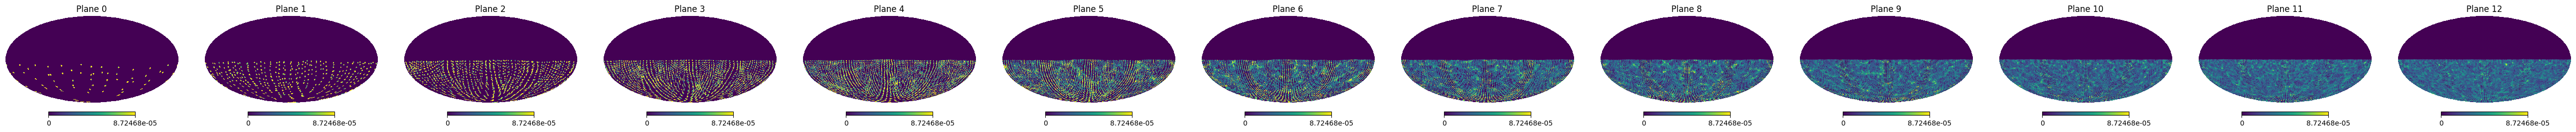

✓ Plotted lightcone to 


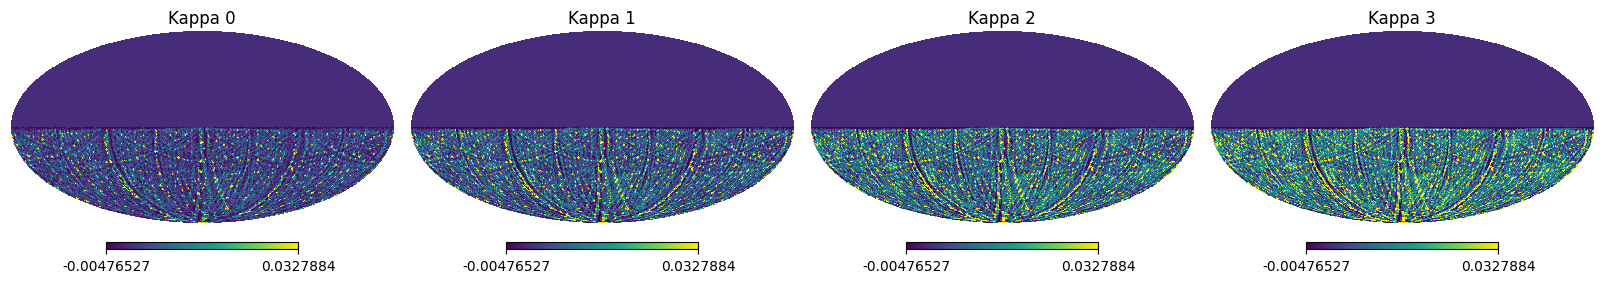

✓ Plotted kappa maps to 


In [19]:
plot_lightcone(true_lightcone, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print(f"✓ Plotted lightcone to ")

# Use full maps for plotting
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print(f"✓ Plotted kappa maps to ")

## 5. Gradient Analysis

Compute gradients of the forward model w.r.t. cosmological parameters using MSE loss relative to fiducial observations.

We evaluate the sensitivity by computing: `loss = mean((kappa_model - kappa_obs)²)` at the fiducial parameters ± offsets.
This shows how changes in Omega_c and sigma8 affect the observables around the true values.

In [23]:
print("\n" + "=" * 60)
print("Creating forward model for gradient analysis")
print("=" * 60)
visible_mask = spherical_visibility_mask(config.nside, config.observer_position)
visible_indices, = jnp.where(visible_mask == 1)

forward_model = make_full_field_model(
    field_size=config.field_size,
    field_npix=config.field_npix,
    box_shape=config.box_shape,
    box_size=config.box_size,
    density_plane_width=config.density_plane_width,
    density_plane_npix=config.density_plane_npix,
    density_plane_smoothing=config.density_plane_smoothing,
    nside=config.nside,
    adjoint=config.adjoint,
    t0=config.t0,
    dt0=config.dt0,
    t1=config.t1,
    min_redshift=config.min_redshift,
    max_redshift=config.max_redshift,
    sharding=config.sharding,
    halo_size=config.halo_size,
    geometry=config.geometry,
    observer_position=config.observer_position,
)

print("✓ Forward model created")

def compute_parameter_gradient(forward_model, cosmo, nz_shear, ic, kappa_obs, param_name, param_value):
    """Compute gradient of MSE loss w.r.t. a cosmological parameter."""
    def loss_for_param(param_val):
        cosmo_dict = {
            "Omega_c": cosmo.Omega_c,
            "Omega_b": cosmo.Omega_b,
            "h": cosmo.h,
            "n_s": cosmo.n_s,
            "sigma8": cosmo.sigma8,
            "Omega_k": cosmo.Omega_k,
            "w0": cosmo.w0,
            "wa": cosmo.wa,
        }
        cosmo_dict[param_name] = param_val
        test_cosmo = jc.Cosmology(**cosmo_dict)
        test_cosmo._workspace = {}
        
        kappas, _, _ = forward_model(test_cosmo, nz_shear, ic)

        kappas = {f"kappa_{i}": k[visible_indices] for i, k in enumerate(kappas)}
        mse = jax.tree.map(lambda k, k_obs: jnp.mean((k - k_obs)**2), kappas, kappa_obs)
        mse = jnp.mean(jnp.array(jax.tree.leaves(mse)))
        return mse
    
    grad_fn = jax.grad(loss_for_param)
    grad_value = grad_fn(param_value)
    
    return float(grad_value)


print("\n" + "=" * 60)
print("Computing parameter gradients for Omega_c")
print("=" * 60)

omega_c_fiducial = fiducial_cosmology.Omega_c
omega_c_offsets = [-2 * gradient_offset_omega_c, -gradient_offset_omega_c, 0.0, 
                   gradient_offset_omega_c, 2 * gradient_offset_omega_c]
omega_c_values = [omega_c_fiducial + offset for offset in omega_c_offsets]
omega_c_gradients = []

for i, (offset, value) in enumerate(zip(omega_c_offsets, omega_c_values)):
    print(f"Computing gradient {i+1}/5: Omega_c = {value:.4f} (offset = {offset:+.4f})")
    grad_value = compute_parameter_gradient(
        forward_model, fiducial_cosmology, nz_shear, 
        initial_conditions, true_kappas_visible, "Omega_c", value
    )
    omega_c_gradients.append(grad_value)
    print(f"  d(MSE)/d(Omega_c): {grad_value:.6e}")

print("\n" + "=" * 60)
print("Computing parameter gradients for sigma8")
print("=" * 60)

sigma8_fiducial = fiducial_cosmology.sigma8
sigma8_offsets = [-2 * gradient_offset_sigma8, -gradient_offset_sigma8, 0.0, 
                  gradient_offset_sigma8, 2 * gradient_offset_sigma8]
sigma8_values = [sigma8_fiducial + offset for offset in sigma8_offsets]
sigma8_gradients = []

for i, (offset, value) in enumerate(zip(sigma8_offsets, sigma8_values)):
    print(f"Computing gradient {i+1}/5: sigma8 = {value:.4f} (offset = {offset:+.4f})")
    grad_value = compute_parameter_gradient(
        forward_model, fiducial_cosmology, nz_shear, 
        initial_conditions, true_kappas_visible, "sigma8", value
    )
    sigma8_gradients.append(grad_value)
    print(f"  d(MSE)/d(sigma8): {grad_value:.6e}")


Creating forward model for gradient analysis
✓ Forward model created

Computing parameter gradients for Omega_c
Computing gradient 1/5: Omega_c = 0.0607 (offset = -0.2000)


/home/wassim/micromamba/envs/jax/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


  d(MSE)/d(Omega_c): nan
Computing gradient 2/5: Omega_c = 0.1607 (offset = -0.1000)
  d(MSE)/d(Omega_c): nan
Computing gradient 3/5: Omega_c = 0.2607 (offset = +0.0000)
  d(MSE)/d(Omega_c): nan
Computing gradient 4/5: Omega_c = 0.3607 (offset = +0.1000)
  d(MSE)/d(Omega_c): nan
Computing gradient 5/5: Omega_c = 0.4607 (offset = +0.2000)
  d(MSE)/d(Omega_c): nan

Computing parameter gradients for sigma8
Computing gradient 1/5: sigma8 = 0.6102 (offset = -0.2000)
  d(MSE)/d(sigma8): nan
Computing gradient 2/5: sigma8 = 0.7102 (offset = -0.1000)
  d(MSE)/d(sigma8): nan
Computing gradient 3/5: sigma8 = 0.8102 (offset = +0.0000)
  d(MSE)/d(sigma8): nan
Computing gradient 4/5: sigma8 = 0.9102 (offset = +0.1000)
  d(MSE)/d(sigma8): nan
Computing gradient 5/5: sigma8 = 1.0102 (offset = +0.2000)
  d(MSE)/d(sigma8): nan


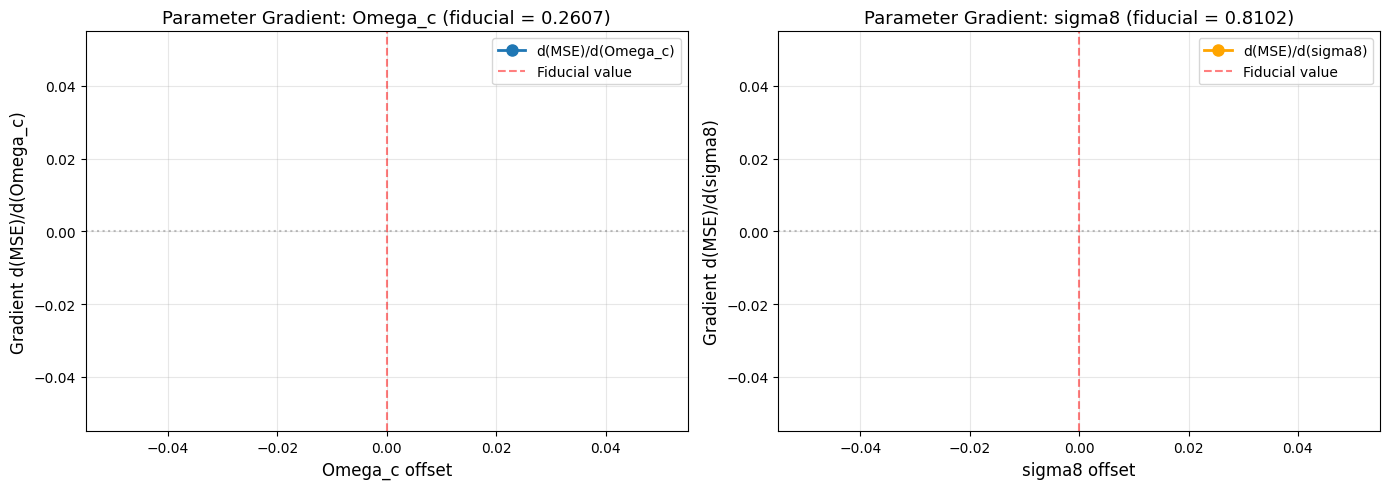


✓ Parameter gradient plots saved to output_notebook/plots/gradient_sensitivity.png


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(omega_c_offsets, omega_c_gradients, 'o-', linewidth=2, markersize=8, label='d(MSE)/d(Omega_c)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Fiducial value')
axes[0].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Omega_c offset', fontsize=12)
axes[0].set_ylabel('Gradient d(MSE)/d(Omega_c)', fontsize=12)
axes[0].set_title(f'Parameter Gradient: Omega_c (fiducial = {omega_c_fiducial:.4f})', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(sigma8_offsets, sigma8_gradients, 'o-', linewidth=2, markersize=8, label='d(MSE)/d(sigma8)', color='orange')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5, label='Fiducial value')
axes[1].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('sigma8 offset', fontsize=12)
axes[1].set_ylabel('Gradient d(MSE)/d(sigma8)', fontsize=12)
axes[1].set_title(f'Parameter Gradient: sigma8 (fiducial = {sigma8_fiducial:.4f})', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(plots_dir / 'gradient_sensitivity.png', dpi=600, bbox_inches='tight')
plt.show()

print(f"\n✓ Parameter gradient plots saved to {plots_dir / 'gradient_sensitivity.png'}")

## 6. MCMC Sampling (Resumable)

This section can be re-run independently to resume sampling or to sample with different parameters.
The `batched_sampling` function saves checkpoints that allow resuming from the last batch.

**⚠️ Important:** If using distributed sharding with NumPyro backend, sharding will be lost on resumption. Use BlackJAX backend for distributed/sharded workflows (see Important Notes in README.md).

In [ ]:
true_data = np.load(data_dir / "true_kappas.npz")
true_kappas_loaded = {f"kappa_{i}": true_data[f"kappa_{i}"] for i in range(nbins)}

print("\n" + "=" * 60)
print("Setting up MCMC inference")
print("=" * 60)

config_inference = config._replace(log_lightcone=False, log_ic=True)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_loaded[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}

print(f"Sampling with {sampler} using {backend} backend")
print(f"Warmup: {num_warmup}, Samples: {num_samples}, Batches: {batch_count}")

In [ ]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params,
)

print("✓ MCMC sampling completed")

🔁 Starting fresh with warmup for MCLMC using blackjax...


## 7. Results and Analysis

Load samples and generate posterior plots and initial condition comparisons.

In [ ]:
print("\n" + "=" * 60)
print("Loading samples and analyzing results")
print("=" * 60)

n_samples_plot = -1

samples = load_samples(str(samples_dir))
if n_samples_plot > 0:
    samples = jax.tree.map(lambda x: x[-n_samples_plot:], samples)
    print(f"Using last {n_samples_plot} samples for plotting")
else:
    print(f"Using all {len(samples['Omega_c'])} samples for plotting")

print(f"Loaded parameters: {list(samples.keys())}")

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

print("\nPosterior Statistics:")
print(f"True Omega_c: {true_Omega_c:.4f}")
print(f"Inferred Omega_c: {samples['Omega_c'].mean():.4f} ± {samples['Omega_c'].std():.4f}")
print(f"True sigma8: {true_sigma8:.4f}")
print(f"Inferred sigma8: {samples['sigma8'].mean():.4f} ± {samples['sigma8'].std():.4f}")

✓ Plotted IC comparison to output_notebook/plots/ic_comparison.png
Removed no burn in


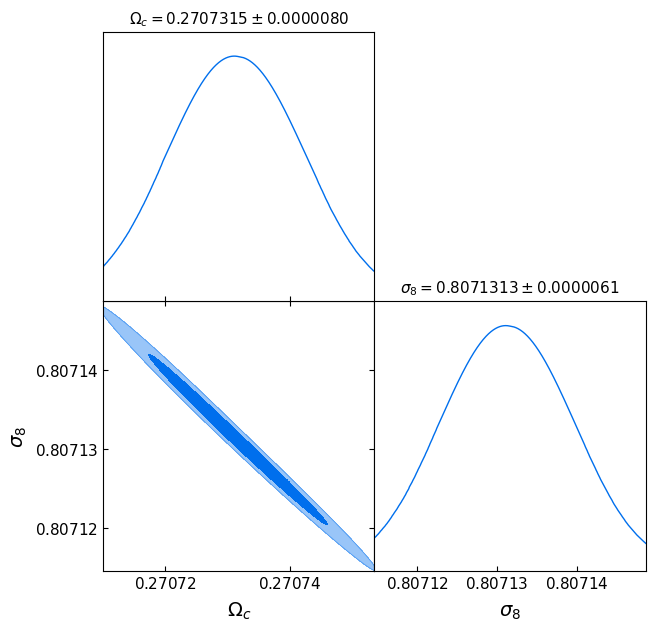

✓ Plotted posteriors to output_notebook/plots/posterior.png


In [ ]:
if "ic" in samples:
    true_ic = np.load(data_dir / "true_ic.npy")
    plot_ic(true_ic, samples["ic"], plots_dir, output_format="png", dpi=600)
    print(f"✓ Plotted IC comparison to {plots_dir / 'ic_comparison.png'}")

param_samples = {
    "Omega_c": samples["Omega_c"],
    "sigma8": samples["sigma8"]
}
true_param_values = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}

# GetDist triangle plot with LaTeX labels (no dollar signs needed)
labels = {
    "Omega_c": r"\Omega_c",
    "sigma8": r"\sigma_8"
}

plot_posterior(
    param_samples,
    plots_dir,
    params=("Omega_c", "sigma8"),
    true_values=true_param_values,
    labels=labels,
    output_format="show",
    filled=True,
    title_limit=1,
    width_inch=7,
)
print(f"✓ Plotted posteriors to {plots_dir / 'posterior.png'}")

## 8. Summary

Workflow completed! Check the output directory for:
- `plots/gradient_sensitivity.png`: Gradient analysis with MSE loss
- `plots/kappa_maps.png`: Convergence maps
- `plots/lightcone.png`: Density planes
- `plots/ic_comparison.png`: Initial conditions comparison
- `plots/posterior_trace.png` and `plots/posterior_pair.png`: Posterior distributions
- `samples/`: MCMC samples (can be reloaded)
- `data/`: True observations and initial conditions